In [1]:

import pandas as pd 
import numpy as np 
import re 
import sys


In [2]:

itTicketDF=pd.read_excel('IT-Ticket-Classification.xlsx')

itTicketDF.head()


,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [3]:
callers = itTicketDF['Caller'].unique() 
display(callers.shape)
itTicketDF.drop(["Caller",'Short description'],axis=1,inplace= True)
itTicketDF.info()

(2950,)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8499 non-null   object
 1   Assignment group  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


In [4]:
targetClassCnt=itTicketDF['Assignment group'].value_counts()
targetClassCnt.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64


#### Observation
Appears the Target class distrubtion is extremely skewed
Large no of entries for GRP_0 (mounting to 3976) which account for ~50% of the data
there are groups with 1 entry also. We could merge all groups with small entries to a group to reduce the imbalance in the target. This may reduce the imbalance to some extent.

In [5]:
sample = itTicketDF.groupby(['Assignment group'])
regroup=[]
for grp in itTicketDF['Assignment group'].unique():
    if(sample.get_group(grp).shape[0]<10):
        regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
itTicketDF['Assignment group']=itTicketDF['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
itTicketDF['Assignment group'].unique()

Found 25 groups which have under 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  # Remove the CWD from sys.path while we load stuff.


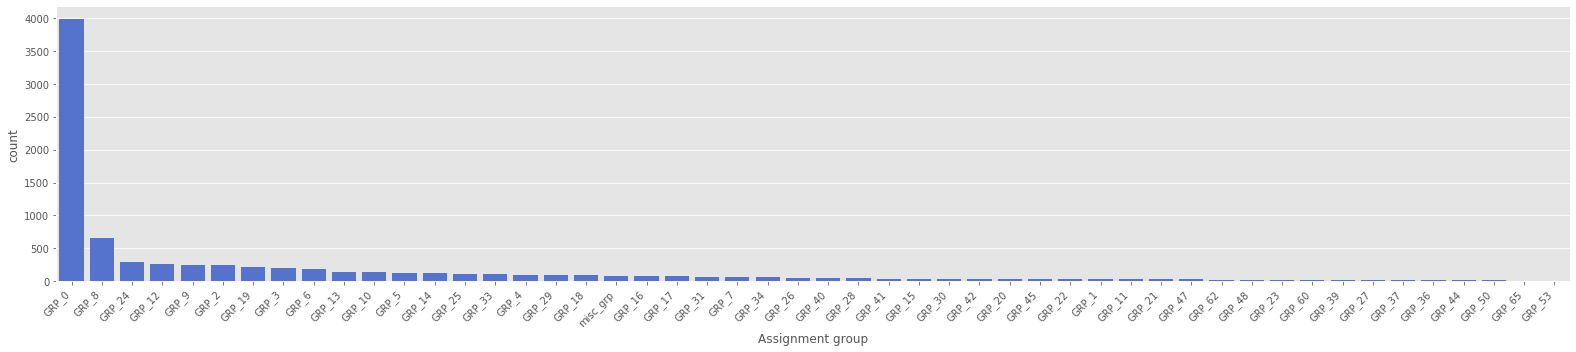

In [6]:
##Pre-Processing label Encoding on  Assignment Group

import seaborn as sns
import matplotlib.pyplot as plt


#add to remove warning for python 3.6 dependency

import warnings
import pandas.util.testing as tm


plt.style.use('ggplot')
%matplotlib inline

descending_order = itTicketDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))

#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=itTicketDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [7]:

#Fill 'Decsription' field entries that have null with blank space
itTicketDF['Description'].fillna(value=' ', inplace=True)

In [8]:
from dateutil import parser


def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False
    

In [9]:
def clean_data(text):
    text=text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove Non Dictionary character-TODO
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
        namelist = [part for part in name.split()]
        for namepart in namelist: 
            text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text



In [10]:

itTicketDF['Description'] = itTicketDF['Description'].apply(clean_data)


In [11]:
itTicketDF['length']=[len(text) for text in itTicketDF['Description']]

itTicketDF=itTicketDF[itTicketDF['length']>=3]

itTicketDF['Description'] = itTicketDF['Description'].apply(lambda x : " ".join([word for word in x.split() if(len(word)>2)]))

#itTicketDF.drop(['length'],axis=1,inplace= True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
# translation


germanwordlist = ['bitte','nicht','konto','probleme','berechtigung','defekt','mehr','ausgetauscht','rechner', 'drucker','teilweise','freigegeben','genannten','anmeldeaccount',
                  'besprochen','werden','durchwahl','oben','einrichten','zeitwirtschaft','seit','morgens','beheben','keine','zeitbuchungen','vorhanden','dringend','fehler',
                  'werk','anmelde','auftrag','kein','skannen','freundlichen','werkzeuge,','hartstoffe','maste','schutzw','fertigung','immer','sehr','zugriff','freundliche',
                  'geehrter','souzarft','noch','verbindungsherstellung','meldung','erneuten','glich','proben','beilageproben','beilage','auswerten','sinterleitstand','reparar',
                  'reparo','rechner','koenigsee','entregar','atualiza','declara','programdntya','funcionando','preciso','hitacni','grergtger','zugriffsrechte','teamleiter',
                  'abholen','wegen','weit','absender','wenn','abrechnung']
pattern = '|'.join(germanwordlist)

pattern

'bitte|nicht|konto|probleme|berechtigung|defekt|mehr|ausgetauscht|rechner|drucker|teilweise|freigegeben|genannten|anmeldeaccount|besprochen|werden|durchwahl|oben|einrichten|zeitwirtschaft|seit|morgens|beheben|keine|zeitbuchungen|vorhanden|dringend|fehler|werk|anmelde|auftrag|kein|skannen|freundlichen|werkzeuge,|hartstoffe|maste|schutzw|fertigung|immer|sehr|zugriff|freundliche|geehrter|souzarft|noch|verbindungsherstellung|meldung|erneuten|glich|proben|beilageproben|beilage|auswerten|sinterleitstand|reparar|reparo|rechner|koenigsee|entregar|atualiza|declara|programdntya|funcionando|preciso|hitacni|grergtger|zugriffsrechte|teamleiter|abholen|wegen|weit|absender|wenn|abrechnung'

In [13]:
germanDescIndex = itTicketDF[itTicketDF['Description'].str.contains(pattern)].index
germanDescIndex

Int64Index([ 223,  238,  251,  255,  265,  270,  272,  302,  304,  305,
            ...
            8414, 8417, 8419, 8420, 8425, 8427, 8436, 8439, 8467, 8499],
           dtype='int64', length=586)

In [31]:
# since translation done by googletrans & textblob is giving error while using checking & translating every row, just checking the "Description" for german word like 'bitte'
#!pip install -q googletrans

from google_trans_new import google_translator  
translator = google_translator()  



def translateIfRequired(x):
   # translator = Translator()
    print("step 1")
   # print(translator.detect(x)[0])
    if translator.detect(x)[0] != 'en':
        print("step 2")
        translatedText = translator.translate(x)
    else:
        translatedText = x
        print("step 3")
    return translatedText






In [32]:
for rowId in germanDescIndex:
    print(itTicketDF['Description'][rowId])
    print("\n\n")
    
    
    
    

hallo ist erneut passiert der hat sich zum wiederholten male aufgeh ngt und mir lediglich einen blauen bildschirm mit weisser schrift sentiert was nnen wir machen



all have connectivity issue between erp and msd crm due certificate renewal azure websites and that certificate not yet updated erp side issue changes data records accounts sales area data partner functions contacts leads are not being processed from erp worked with msd crm and vice versa all environments prod and dev issue start time troubleshooting steps when tryhdty from customer master team reported the issue that prospect account created erp didn come into msd yet erp team observed that the records are still awaiting acknowledgement status which basically means they are not yet delivered received the target system upon some log analysis and trying identify the root cause between erp basis and msd teams been observed that the issue has started production environment since around est observed the same behavior with azur

In [36]:


translateIfRequired('hallo ist erneut passiert der hat sich zum wiederholten male aufgeh \
ngt und mir lediglich einen blauen bildschirm mit weisser schrift sentiert\
was nnen wir machen')


step 1
step 2


'hello happened again, he hung himself up again and again and just sent me a blue screen with white letters, what we can do '